In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


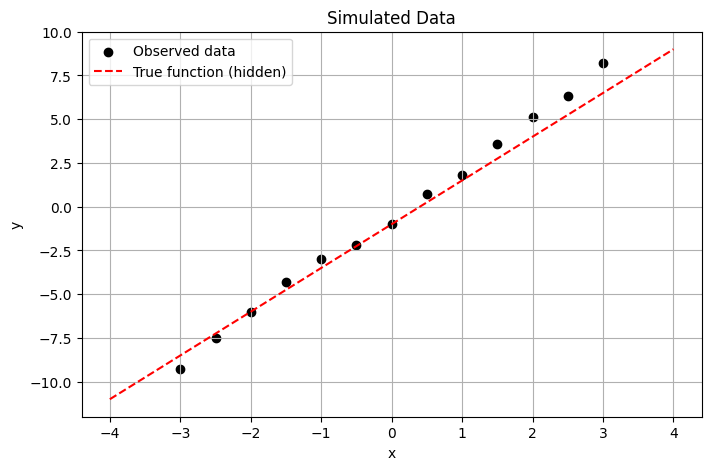

In [ ]:
# Simulate data from a linear function with Gaussian noise
X = np.array([-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3])
y = np.array([-9.3, -7.5, -6.0, -4.3, -3.0, -2.2, -1.0, 0.7, 1.8, 3.6, 5.1, 6.3, 8.2])

# Optional: visualize true function
true_w, true_b = 2.5, -1.0
x_line = np.linspace(-4, 4, 100)
y_true = true_w * x_line + true_b

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X, y, c='black', label='Observed data')
plt.plot(x_line, y_true, 'r--', label='True function (hidden)')
plt.title("Simulated Data")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Simulate posterior samples for weights and bias
n_samples = 100
w_samples = np.random.normal(loc=2.5, scale=0.3, size=n_samples)
b_samples = np.random.normal(loc=-1.0, scale=0.5, size=n_samples)

print("Sampled weights:", w_samples[:5])
print("Sampled biases:", b_samples[:5])


Sampled weights: [2.60733621 2.66823536 2.82491537 2.81614062 2.08669919]
Sampled biases: [-1.41449751 -1.28009052 -0.6263532  -0.69481487 -1.0104508 ]


In [8]:
# Create test points
X_test = np.linspace(-4, 4, 100)

# Generate predictions from each posterior sample
Y_samples = np.array([w * X_test + b for w, b in zip(w_samples, b_samples)])
print("Shape of Y_samples:", Y_samples.shape)


Shape of Y_samples: (100, 100)


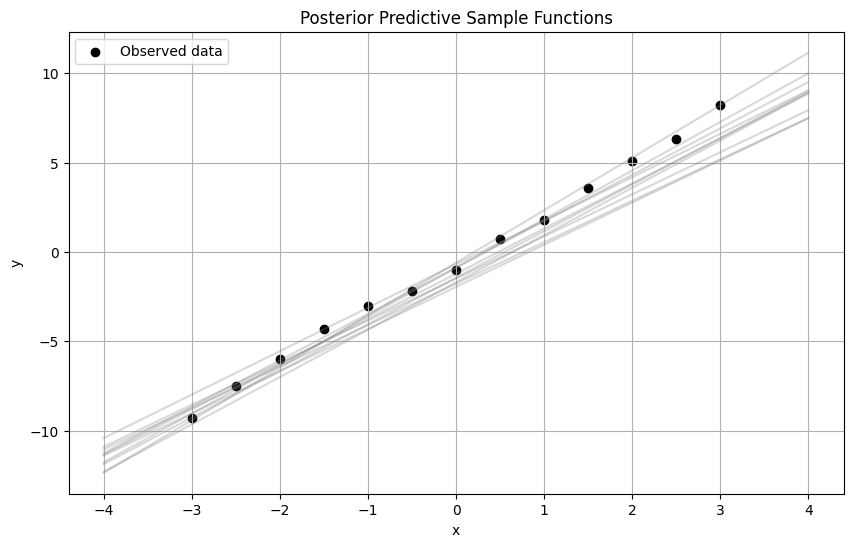

In [6]:
# Plot posterior predictive sample lines
plt.figure(figsize=(10, 6))
for i in range(0, n_samples, 10):
    plt.plot(X_test, Y_samples[i], color='gray', alpha=0.3)

plt.scatter(X, y, color='black', label='Observed data')
plt.title("Posterior Predictive Sample Functions")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.legend()
plt.show()


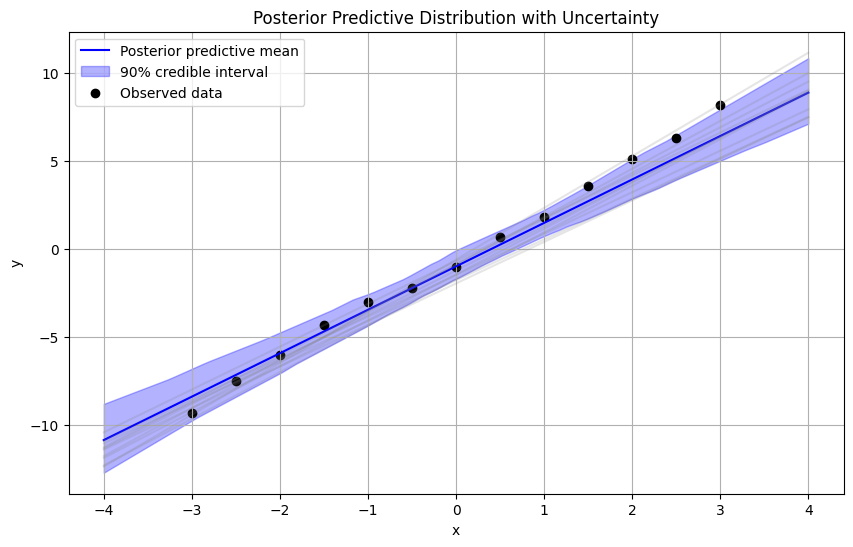

In [7]:
# Compute posterior predictive mean and 90% credible interval
y_mean = Y_samples.mean(axis=0)
y_low = np.percentile(Y_samples, 5, axis=0)
y_high = np.percentile(Y_samples, 95, axis=0)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_mean, 'b-', label='Posterior predictive mean')
plt.fill_between(X_test, y_low, y_high, alpha=0.3, color='blue', label='90% credible interval')
plt.scatter(X, y, color='black', label='Observed data')

for i in range(0, n_samples, 10):
    plt.plot(X_test, Y_samples[i], color='gray', alpha=0.2)

plt.title("Posterior Predictive Distribution with Uncertainty")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


🧠 Cell 2: Simulated MRI
We created a simple 2D image representing a T2-weighted prostate MRI:

A central Gaussian blob simulates the prostate gland.

A smaller, off-center bump mimics a PI-RADS 3+ lesion.

This will be our ground truth from which we'll simulate undersampled reconstructions with uncertainty.

Next: let's implement Gaussian Monte Carlo UQ (MC sampling in k-space). 

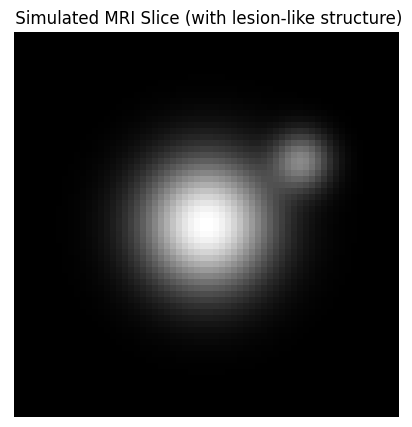

In [ ]:
# Cell 1: Imports and utility setup 📦
import numpy as np
import matplotlib.pyplot as plt

# Utility: add some noise to mimic MRI k-space uncertainty
def add_noise(image, stddev=0.05):
    noise = np.random.normal(0, stddev, image.shape)
    return image + noise

# Utility: simulate structured dropout in k-space (leave-X-out mask)
def leave_x_out(image, x=4):
    masked = image.copy()
    masked[::x] = 0  # simulate dropout every x lines
    return masked

# Utility: fake reconstruction process (identity here, for illustration)
def reconstruct(image):
    return image  # placeholder for a learned model (e.g., vSHARP) in real scenario


# Cell 2: Simulate a simple "MRI-like" image 🧠📷

# Simulated 2D image (toy prostate MRI)
np.random.seed(0)
image_size = 64
x = np.linspace(-3, 3, image_size)
X, Y = np.meshgrid(x, x)
image = np.exp(-(X**2 + Y**2)) + 0.5 * np.exp(-((X - 1.5)**2 + (Y + 1.0)**2) / 0.2)  # Prostate + lesion-like blob

# Plot original image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.title("Simulated MRI Slice (with lesion-like structure)")
plt.axis('off')
plt.show()



# Cell 3: Gaussian Monte Carlo UQ 🌀 (noise-injected reconstructions)


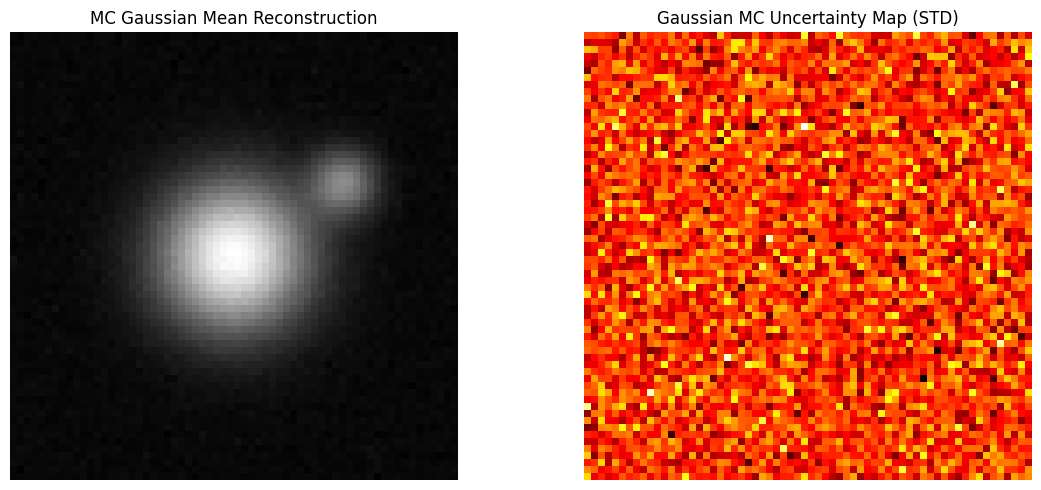

In [14]:
n_samples = 30
gaussian_recons = []

for _ in range(n_samples):
    noisy_kspace = add_noise(image, stddev=0.05)
    recon = reconstruct(noisy_kspace)
    gaussian_recons.append(recon)

gaussian_recons = np.stack(gaussian_recons)
gaussian_std_map = np.std(gaussian_recons, axis=0)

# Plot uncertainty map
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(gaussian_recons, axis=0), cmap='gray')
plt.title("MC Gaussian Mean Reconstruction")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gaussian_std_map, cmap='hot')
plt.title("Gaussian MC Uncertainty Map (STD)")
plt.axis('off')
plt.tight_layout()
plt.show()


/tmp/ipykernel_2444606/4256752829.py:26: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


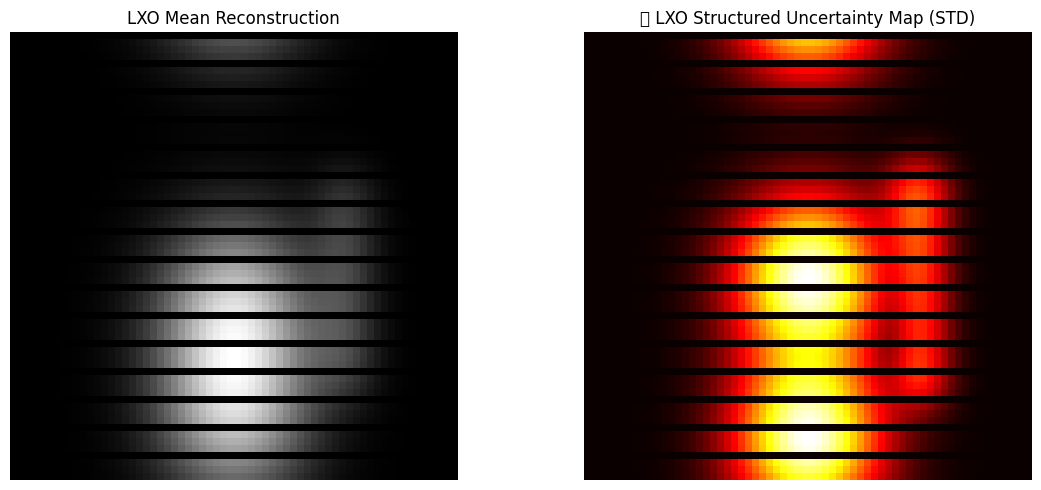

In [15]:
# Cell 4: Structured UQ via Leave-X-Out (LXO) 🚧

lxo_recons = []
leave_out_every = 4  # every 4th line dropped

for i in range(n_samples):
    rotated = np.roll(image, shift=i, axis=0)  # rotate dropout pattern
    dropped = leave_x_out(rotated, x=leave_out_every)
    recon = reconstruct(dropped)
    lxo_recons.append(recon)

lxo_recons = np.stack(lxo_recons)
lxo_std_map = np.std(lxo_recons, axis=0)

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.mean(lxo_recons, axis=0), cmap='gray')
plt.title("LXO Mean Reconstruction")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(lxo_std_map, cmap='hot')
plt.title("🔥 LXO Structured Uncertainty Map (STD)")
plt.axis('off')
plt.tight_layout()
plt.show()


# Another better example
🔁 Suggested Teaching Example
Let’s build a toy BNN that takes in a blurred digit and tries to reconstruct the sharp digit — using MC Dropout as a proxy for the posterior. We’ll then:

Show multiple samples (posterior draws),

Compute the posterior predictive variance,

Compare that with the actual error.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

Shape of X: (1797, 8, 8)
Shape of y: (1797,)
Pixel value range: 0.0 to 1.0


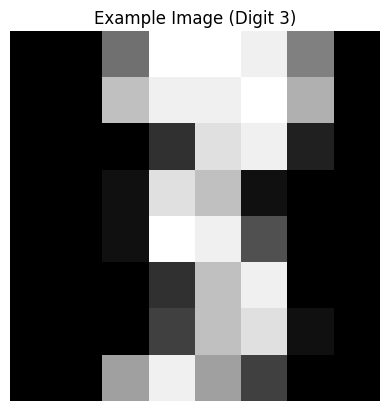

In [26]:
# Ensure CPU only
device = torch.device("cpu")

# Load digits dataset (8x8 grayscale images, pixel values 0–16)
digits = load_digits()
X = digits.images / 16.0  # normalize to [0, 1]
y = digits.target

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

#print the range of pixel values
print("Pixel value range:", X.min(), "to", X.max())

# Use only one class (e.g., digit "3") for denoising/regression
mask = y == 3
X = X[mask]

#viusalize the first image
plt.imshow(X[-5], cmap='gray')
plt.title("Example Image (Digit 3)")
plt.axis('off')
plt.show()

In [ ]:
# Simulate a blurry version of each image
def gaussian_blur(img):
    from scipy.ndimage import gaussian_filter
    return gaussian_filter(img, sigma=1)

X_blurred = np.array([gaussian_blur(im) for im in X])

# Reshape and convert to torch tensors
X_blurred = torch.tensor(X_blurred[:, None, :, :], dtype=torch.float32)  # shape [N, 1, 8, 8]
X_sharp = torch.tensor(X[:, None, :, :], dtype=torch.float32)

# Split into train/test
Xb_train, Xb_test, Xs_train, Xs_test = train_test_split(X_blurred, X_sharp, test_size=0.3, random_state=42)

# Package into dataloaders
train_ds = TensorDataset(Xb_train, Xs_train)
test_ds = TensorDataset(Xb_test, Xs_test)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

✅ Step 1: Build an MC Dropout Model (Posterior Approx)

In [25]:
class MCDropoutCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(16, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.conv(x)


In [30]:
import os

def train_model(model, train_loader, test_loader, n_epochs=100, patience=10, save_path="mc_dropout_model.pt"):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                loss = loss_fn(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(test_loader.dataset)

        print(f"Epoch {epoch+1:02d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), save_path)
            print("📦 Saved best model.")
        else:
            counter += 1
            print(f"⏳ No improvement for {counter} epochs.")
            if counter >= patience:
                print("⏹️ Early stopping triggered.")
                break


model = MCDropoutCNN()
train_model(model, train_loader, test_loader, n_epochs=100, patience=10)



Epoch 01: Train Loss = 0.2395, Val Loss = 0.2171
📦 Saved best model.
Epoch 02: Train Loss = 0.2112, Val Loss = 0.1878
📦 Saved best model.
Epoch 03: Train Loss = 0.1815, Val Loss = 0.1587
📦 Saved best model.
Epoch 04: Train Loss = 0.1604, Val Loss = 0.1324
📦 Saved best model.
Epoch 05: Train Loss = 0.1335, Val Loss = 0.1111
📦 Saved best model.
Epoch 06: Train Loss = 0.1180, Val Loss = 0.0941
📦 Saved best model.
Epoch 07: Train Loss = 0.1053, Val Loss = 0.0809
📦 Saved best model.
Epoch 08: Train Loss = 0.0921, Val Loss = 0.0717
📦 Saved best model.
Epoch 09: Train Loss = 0.0834, Val Loss = 0.0652
📦 Saved best model.
Epoch 10: Train Loss = 0.0836, Val Loss = 0.0591
📦 Saved best model.
Epoch 11: Train Loss = 0.0739, Val Loss = 0.0546
📦 Saved best model.
Epoch 12: Train Loss = 0.0738, Val Loss = 0.0516
📦 Saved best model.
Epoch 13: Train Loss = 0.0693, Val Loss = 0.0499
📦 Saved best model.
Epoch 14: Train Loss = 0.0631, Val Loss = 0.0488
📦 Saved best model.
Epoch 15: Train Loss = 0.0622, Val

KeyboardInterrupt: 

Number of test samples: 55


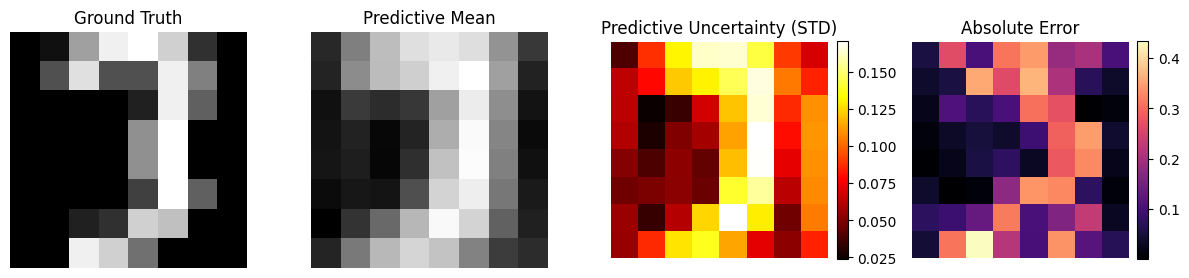

🔗 Pearson correlation between uncertainty and error: r = 0.552


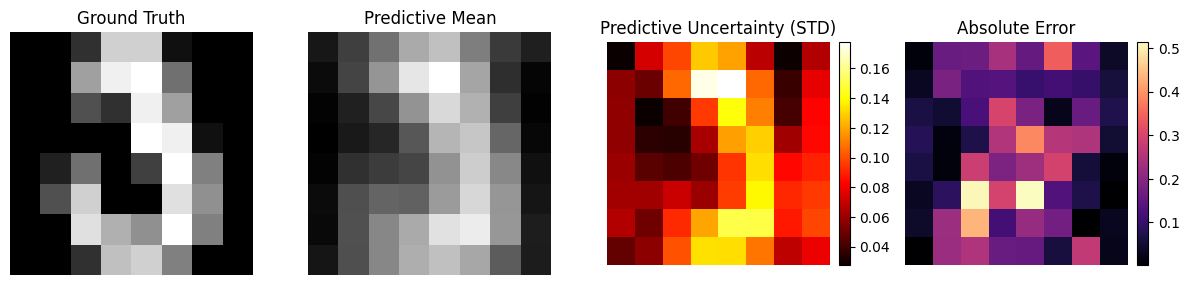

🔗 Pearson correlation between uncertainty and error: r = 0.177


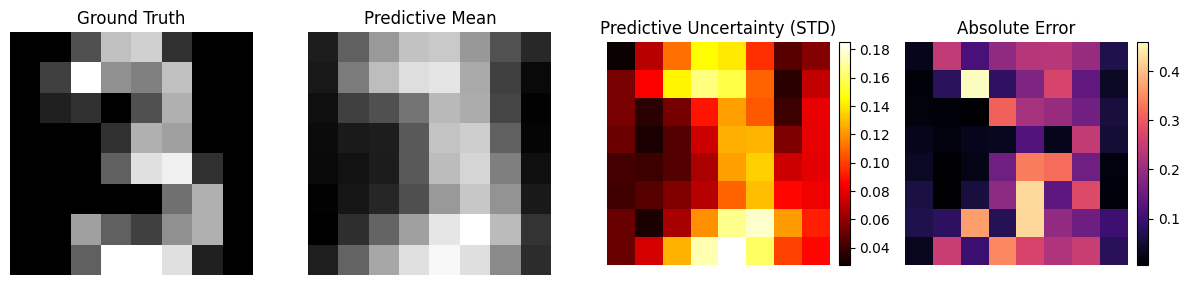

🔗 Pearson correlation between uncertainty and error: r = 0.550


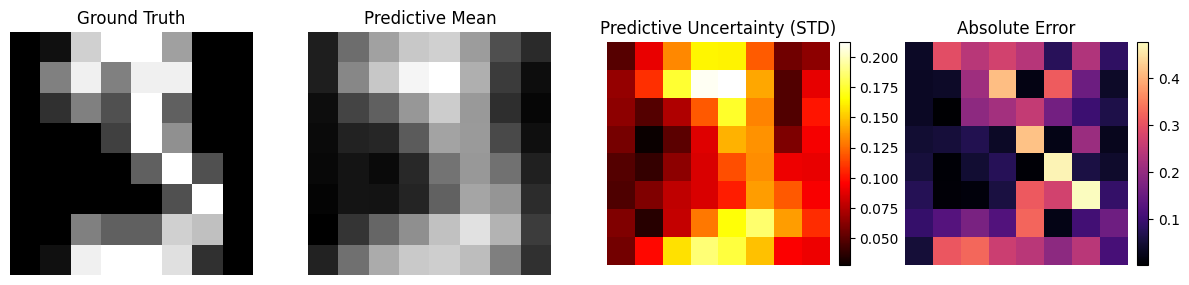

🔗 Pearson correlation between uncertainty and error: r = 0.495


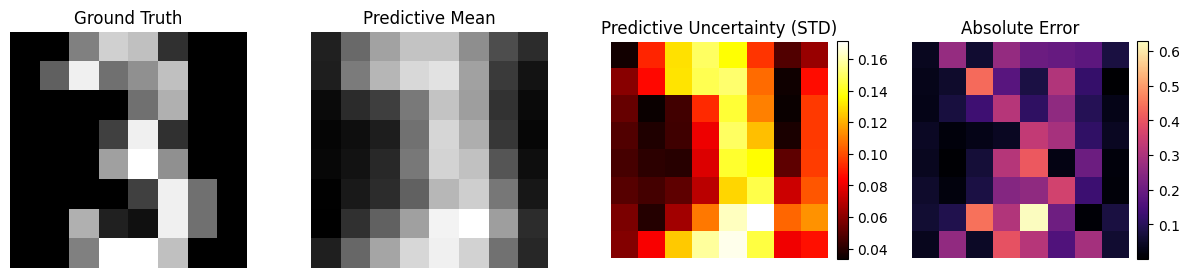

🔗 Pearson correlation between uncertainty and error: r = 0.506


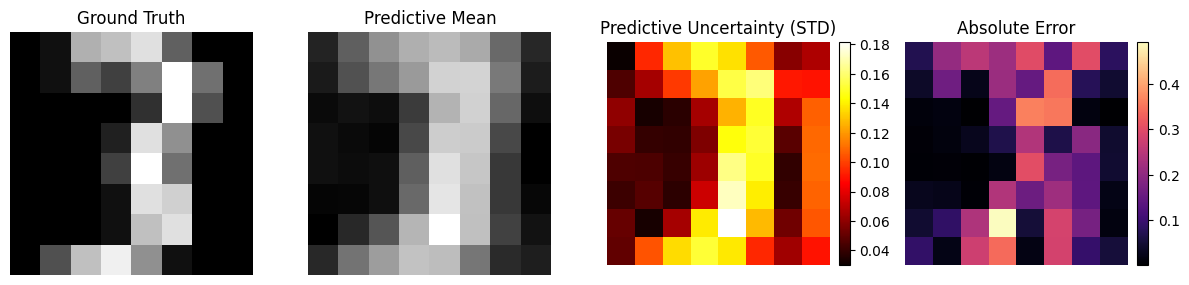

🔗 Pearson correlation between uncertainty and error: r = 0.527


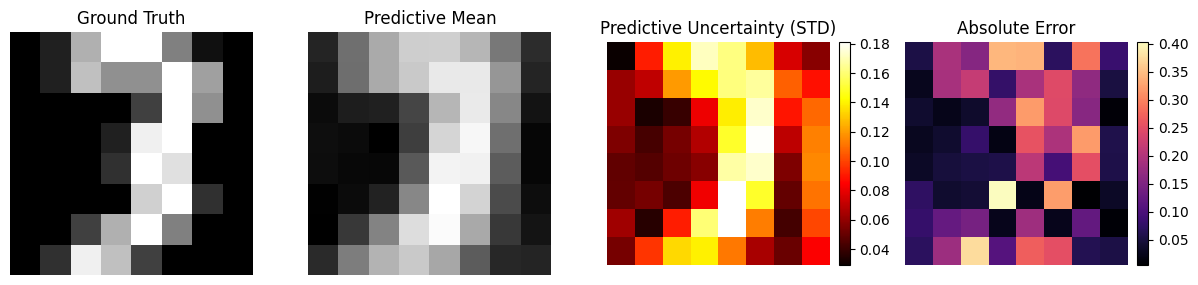

🔗 Pearson correlation between uncertainty and error: r = 0.414


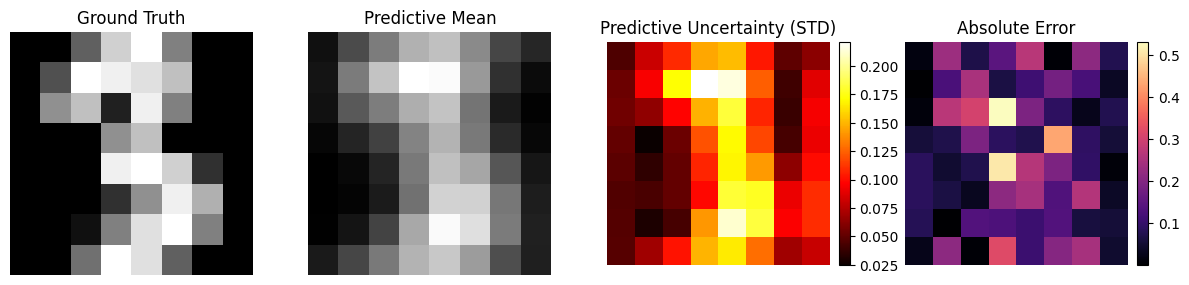

🔗 Pearson correlation between uncertainty and error: r = 0.311


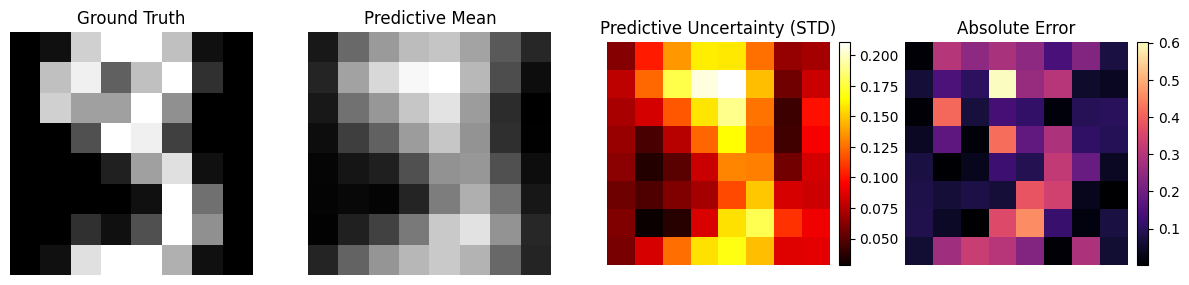

🔗 Pearson correlation between uncertainty and error: r = 0.507


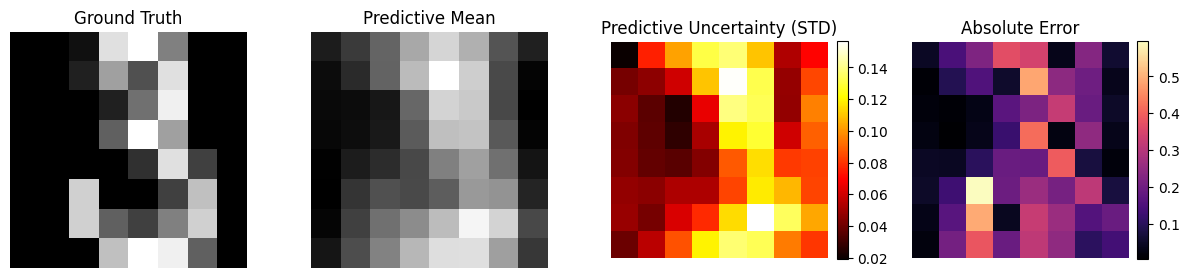

🔗 Pearson correlation between uncertainty and error: r = 0.473


In [41]:
from scipy.stats import pearsonr

def mc_sample_predictions(model, x, n_samples=50):
    model.train()  # ensure dropout is active
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            out = model(x)  # shape: [1, 1, 8, 8]
            preds.append(out.squeeze(0).squeeze(0).numpy())  # shape: [8, 8]
    print(f"Sampled {len(preds)} predictions with dropout enabled.")
    return np.stack(preds)  # shape: [samples, 8, 8]


# Reload your trained model (with dropout)
model = MCDropoutCNN()
model.load_state_dict(torch.load("mc_dropout_model.pt"))
model = model.to("cpu")  # ensure CPU
model.train()  # 🧠 keep dropout ON to enable MC sampling


for idx in range(len(Xb_test)):
    if idx >= 10:
        break

    # Get one blurred input and ground truth sharp image
    x_blur = Xb_test[idx].unsqueeze(0)  # shape: [1, 1, 8, 8]
    x_sharp = Xs_test[idx].squeeze().numpy()  # shape: [8, 8]

    samples = mc_sample_predictions(model, x_blur, n_samples=50)

    mean_pred = samples.mean(axis=0)
    std_pred = samples.std(axis=0)
    abs_error = np.abs(mean_pred - x_sharp)


    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(x_sharp, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mean_pred, cmap="gray")
    plt.title("Predictive Mean")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(std_pred, cmap="hot")
    plt.title("Predictive Uncertainty (STD)")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(abs_error, cmap="magma")
    plt.title("Absolute Error")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    corr, _ = pearsonr(std_pred.flatten(), abs_error.flatten())
    print(f"🔗 Pearson correlation between uncertainty and error: r = {corr:.3f}")
